## Deep Learning on FashionMNIST

*Import Libraries*

In [17]:
import time
import numpy as np
K.set_image_data_format("channels_last")

import matplotlib.pyplot as plt
#from livelossplot import PlotLossesKeras
from PIL import Image
import datetime

from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectPercentile, chi2, SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import cv2
sift = cv2.SIFT_create()

*Function Def*

In [11]:
def load_fashion_mnist_dataset():
    from keras.datasets import fashion_mnist
    ((x_train, y_train), (x_test, y_test)) = fashion_mnist.load_data()
    return (x_train, y_train), (x_test, y_test)


# Visualizar 6 imagens do mnist numa escala de cinzentos
def visualize_fashion_mnist():
    (X_train, y_train), (X_test, y_test) = load_fashion_mnist_dataset()
    plt.subplot(321)
    plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
    plt.subplot(322)
    plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
    plt.subplot(323)
    plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
    plt.subplot(324)
    plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
    plt.subplot(325)
    plt.imshow(X_train[4], cmap=plt.get_cmap('gray'))
    plt.subplot(326)
    plt.imshow(X_train[5], cmap=plt.get_cmap('gray'))
    plt.show()

def getImage(img_mat, gray=True, plot=False):
    '''
        @description returns a 32x32 image given a single row
        repr of the image
        _Optionally plots the image_
        @param img_mat -> np.array: |img_mat| = (3072, ) OR (3072, 1)
        @param plot -> bool: whether to plot it or not
        @return image_repr: np.ndarray |image_repr| = (32, 32, 3)
    '''
    assert img_mat.shape in [(3072,), (3072, 1)] # sanity check
    r_channel = img_mat[:1024].reshape(32, 32)
    g_channel = img_mat[1024: 2 * 1024].reshape(32, 32)
    b_channel = img_mat[2 * 1024:].reshape(32, 32)
    image_repr = np.stack([r_channel, g_channel, b_channel], axis=2)
    assert image_repr.shape == (32, 32, 3) # sanity check
    if plot:
        import matplotlib.pyplot as plt
        plt.imshow(image_repr), plt.show(block=False)

    return cv2.cvtColor(image_repr, cv2.COLOR_RGB2GRAY)

def show_rgb_img(img):
    return plt.imshow(cv2.cvtColor(img, cv2.CV_32S))

def to_gray(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray

def gen_sift_features(gray_img):
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

def show_sift_features(gray_img, color_img, kp):
    return plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))

def getSIFT(img):
    '''
        @description Get the SIFT features of the input image
        @param img -> np.array: |img| => { (32, 32), (3072, 1||0) }
        @return descriptor -> np.array n x 128
    '''
    if img.shape in [(3072, 1), (3072,)]: img = getImage(img)
    kps, des = sift.detectAndCompute(img, None)
    return des if des is not None else np.array([]).reshape(0, 128)

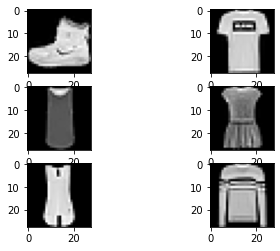

In [3]:
visualize_fashion_mnist()

## SIFT Based Classification

**Load the dataset**

In [8]:
(X_train, y_train), (X_test, y_test) = load_fashion_mnist_dataset()

In [15]:
descriptors = []

start = time.time()
for img in X_train:
    des = getSIFT(img)
    for d in des:
        descriptors.append(d)
end = time.time()
Time: %0.2f" % (end - start), "seconds")

*Clustering With KMeans*

In [22]:
k=10**3
start = time.time()
kmeans = MiniBatchKMeans(n_clusters=k, verbose=1).fit(descriptors)
end = time.time()

Init 1/3 with method: k-means++


C:\Users\enric\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1672: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  cluster_centers = _init_centroids(


Inertia for init 1/3: 2409455.750000
Init 2/3 with method: k-means++


C:\Users\enric\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1672: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  cluster_centers = _init_centroids(


Inertia for init 2/3: 2004377.374444
Init 3/3 with method: k-means++


C:\Users\enric\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1672: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  cluster_centers = _init_centroids(


Inertia for init 3/3: 2350375.243056
Minibatch iteration 1/241400: mean batch inertia: 55319.602567, ewa inertia: 55319.602567 
Minibatch iteration 2/241400: mean batch inertia: 56849.923785, ewa inertia: 55320.870465 
Minibatch iteration 3/241400: mean batch inertia: 55576.365910, ewa inertia: 55321.082147 
Minibatch iteration 4/241400: mean batch inertia: 52387.599118, ewa inertia: 55318.651705 
Minibatch iteration 5/241400: mean batch inertia: 56540.939171, ewa inertia: 55319.664392 
Minibatch iteration 6/241400: mean batch inertia: 50020.655957, ewa inertia: 55315.274070 
Minibatch iteration 7/241400: mean batch inertia: 54062.955023, ewa inertia: 55314.236502 
Minibatch iteration 8/241400: mean batch inertia: 54428.562666, ewa inertia: 55313.502705 
Minibatch iteration 9/241400: mean batch inertia: 50770.323553, ewa inertia: 55309.738601 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 10/241400: mean batch inertia: 47998.478370, ewa inertia: 55303.681094 
Mi

[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 90/241400: mean batch inertia: 44761.057525, ewa inertia: 54615.763966 
Minibatch iteration 91/241400: mean batch inertia: 36875.505563, ewa inertia: 54601.065850 
Minibatch iteration 92/241400: mean batch inertia: 41831.297254, ewa inertia: 54590.485872 
Minibatch iteration 93/241400: mean batch inertia: 44870.196941, ewa inertia: 54582.432442 
Minibatch iteration 94/241400: mean batch inertia: 37867.212634, ewa inertia: 54568.583589 
Minibatch iteration 95/241400: mean batch inertia: 40815.918786, ewa inertia: 54557.189264 
Minibatch iteration 96/241400: mean batch inertia: 44644.104405, ewa inertia: 54548.976099 
Minibatch iteration 97/241400: mean batch inertia: 37084.189861, ewa inertia: 54534.506217 
Minibatch iteration 98/241400: mean batch inertia: 39050.392860, ewa inertia: 54521.677357 
Minibatch iteration 99/241400: mean batch inertia: 37860.828601, ewa inertia: 54507.873551 
[MiniBatchKMeans] Reassigning 

Minibatch iteration 181/241400: mean batch inertia: 37694.474173, ewa inertia: 53487.946855 
Minibatch iteration 182/241400: mean batch inertia: 37829.754129, ewa inertia: 53474.973768 
Minibatch iteration 183/241400: mean batch inertia: 39587.557069, ewa inertia: 53463.467799 
Minibatch iteration 184/241400: mean batch inertia: 34323.338323, ewa inertia: 53447.609865 
Minibatch iteration 185/241400: mean batch inertia: 40443.408790, ewa inertia: 53436.835656 
Minibatch iteration 186/241400: mean batch inertia: 39010.858965, ewa inertia: 53424.883481 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 187/241400: mean batch inertia: 38941.753670, ewa inertia: 53412.883953 
Minibatch iteration 188/241400: mean batch inertia: 37057.891752, ewa inertia: 53399.333555 
Minibatch iteration 189/241400: mean batch inertia: 40975.639462, ewa inertia: 53389.040306 
Minibatch iteration 190/241400: mean batch inertia: 38655.594870, ewa inertia: 53376.833387 
Minibatch iteration 

Minibatch iteration 267/241400: mean batch inertia: 34891.836342, ewa inertia: 52418.279474 
Minibatch iteration 268/241400: mean batch inertia: 34875.444139, ewa inertia: 52403.744926 
Minibatch iteration 269/241400: mean batch inertia: 35736.007513, ewa inertia: 52389.935413 
Minibatch iteration 270/241400: mean batch inertia: 39693.797021, ewa inertia: 52379.416439 
Minibatch iteration 271/241400: mean batch inertia: 40149.470805, ewa inertia: 52369.283714 
Minibatch iteration 272/241400: mean batch inertia: 45801.616842, ewa inertia: 52363.842287 
Minibatch iteration 273/241400: mean batch inertia: 36681.461223, ewa inertia: 52350.849158 
Minibatch iteration 274/241400: mean batch inertia: 35784.481046, ewa inertia: 52337.123631 
Minibatch iteration 275/241400: mean batch inertia: 38471.067458, ewa inertia: 52325.635360 
Minibatch iteration 276/241400: mean batch inertia: 37607.007143, ewa inertia: 52313.440718 
Minibatch iteration 277/241400: mean batch inertia: 41961.776191, ewa 

Minibatch iteration 356/241400: mean batch inertia: 35406.840705, ewa inertia: 51349.949270 
Minibatch iteration 357/241400: mean batch inertia: 41144.851689, ewa inertia: 51341.494167 
Minibatch iteration 358/241400: mean batch inertia: 33260.515794, ewa inertia: 51326.513758 
Minibatch iteration 359/241400: mean batch inertia: 32960.431695, ewa inertia: 51311.297137 
Minibatch iteration 360/241400: mean batch inertia: 42495.437322, ewa inertia: 51303.993042 
Minibatch iteration 361/241400: mean batch inertia: 36835.073081, ewa inertia: 51292.005287 
Minibatch iteration 362/241400: mean batch inertia: 36304.462317, ewa inertia: 51279.587845 
Minibatch iteration 363/241400: mean batch inertia: 36317.575364, ewa inertia: 51267.191554 
Minibatch iteration 364/241400: mean batch inertia: 33703.388872, ewa inertia: 51252.639635 
Minibatch iteration 365/241400: mean batch inertia: 42336.952064, ewa inertia: 51245.252831 
Minibatch iteration 366/241400: mean batch inertia: 35546.479831, ewa 

Minibatch iteration 457/241400: mean batch inertia: 36459.098915, ewa inertia: 50129.616432 
Minibatch iteration 458/241400: mean batch inertia: 33930.857002, ewa inertia: 50116.195475 
Minibatch iteration 459/241400: mean batch inertia: 38788.893301, ewa inertia: 50106.810606 
Minibatch iteration 460/241400: mean batch inertia: 37137.197954, ewa inertia: 50096.065054 
Minibatch iteration 461/241400: mean batch inertia: 35785.253595, ewa inertia: 50084.208295 
Minibatch iteration 462/241400: mean batch inertia: 34563.718577, ewa inertia: 50071.349297 
Minibatch iteration 463/241400: mean batch inertia: 34454.873675, ewa inertia: 50058.410772 
Minibatch iteration 464/241400: mean batch inertia: 32984.985425, ewa inertia: 50044.265139 
Minibatch iteration 465/241400: mean batch inertia: 35647.338277, ewa inertia: 50032.337032 
Minibatch iteration 466/241400: mean batch inertia: 35828.693955, ewa inertia: 50020.569064 
Minibatch iteration 467/241400: mean batch inertia: 38388.465399, ewa 

Minibatch iteration 558/241400: mean batch inertia: 32258.812280, ewa inertia: 49006.348988 
Minibatch iteration 559/241400: mean batch inertia: 36753.101993, ewa inertia: 48996.196957 
Minibatch iteration 560/241400: mean batch inertia: 37847.727804, ewa inertia: 48986.960255 
Minibatch iteration 561/241400: mean batch inertia: 33269.827966, ewa inertia: 48973.938334 
Minibatch iteration 562/241400: mean batch inertia: 35539.911906, ewa inertia: 48962.808007 
Minibatch iteration 563/241400: mean batch inertia: 37250.639963, ewa inertia: 48953.104270 
Minibatch iteration 564/241400: mean batch inertia: 37917.662224, ewa inertia: 48943.961212 
Minibatch iteration 565/241400: mean batch inertia: 37067.187466, ewa inertia: 48934.121097 
Minibatch iteration 566/241400: mean batch inertia: 36551.430503, ewa inertia: 48923.861820 
Minibatch iteration 567/241400: mean batch inertia: 36073.684758, ewa inertia: 48913.215222 
Minibatch iteration 568/241400: mean batch inertia: 36721.932377, ewa 

Minibatch iteration 660/241400: mean batch inertia: 38426.578753, ewa inertia: 47942.750373 
Minibatch iteration 661/241400: mean batch inertia: 39338.975673, ewa inertia: 47935.621995 
Minibatch iteration 662/241400: mean batch inertia: 38493.249204, ewa inertia: 47927.798823 
Minibatch iteration 663/241400: mean batch inertia: 35172.190139, ewa inertia: 47917.230577 
Minibatch iteration 664/241400: mean batch inertia: 34673.401582, ewa inertia: 47906.257832 
Minibatch iteration 665/241400: mean batch inertia: 33244.353595, ewa inertia: 47894.110186 
Minibatch iteration 666/241400: mean batch inertia: 36102.377866, ewa inertia: 47884.340529 
Minibatch iteration 667/241400: mean batch inertia: 39388.662845, ewa inertia: 47877.301711 
Minibatch iteration 668/241400: mean batch inertia: 40375.423728, ewa inertia: 47871.086273 
Minibatch iteration 669/241400: mean batch inertia: 34762.520199, ewa inertia: 47860.225596 
Minibatch iteration 670/241400: mean batch inertia: 36510.453333, ewa 

Minibatch iteration 760/241400: mean batch inertia: 38410.498986, ewa inertia: 46944.178098 
Minibatch iteration 761/241400: mean batch inertia: 36739.858252, ewa inertia: 46935.723640 
Minibatch iteration 762/241400: mean batch inertia: 37370.057367, ewa inertia: 46927.798317 
Minibatch iteration 763/241400: mean batch inertia: 29615.366926, ewa inertia: 46913.454664 
Minibatch iteration 764/241400: mean batch inertia: 35982.414309, ewa inertia: 46904.398105 
Minibatch iteration 765/241400: mean batch inertia: 36474.928296, ewa inertia: 46895.757106 
Minibatch iteration 766/241400: mean batch inertia: 31189.309267, ewa inertia: 46882.744038 
Minibatch iteration 767/241400: mean batch inertia: 36440.964543, ewa inertia: 46874.092840 
Minibatch iteration 768/241400: mean batch inertia: 34695.399614, ewa inertia: 46864.002578 
Minibatch iteration 769/241400: mean batch inertia: 37365.469059, ewa inertia: 46856.132876 
Minibatch iteration 770/241400: mean batch inertia: 31988.965367, ewa 

Minibatch iteration 861/241400: mean batch inertia: 30572.849178, ewa inertia: 46032.896815 
Minibatch iteration 862/241400: mean batch inertia: 35139.291886, ewa inertia: 46023.871272 
Minibatch iteration 863/241400: mean batch inertia: 33590.833082, ewa inertia: 46013.570281 
Minibatch iteration 864/241400: mean batch inertia: 36049.698031, ewa inertia: 46005.315038 
Minibatch iteration 865/241400: mean batch inertia: 31795.484584, ewa inertia: 45993.541944 
Minibatch iteration 866/241400: mean batch inertia: 32227.588162, ewa inertia: 45982.136609 
Minibatch iteration 867/241400: mean batch inertia: 34308.710159, ewa inertia: 45972.464970 
Minibatch iteration 868/241400: mean batch inertia: 35497.535953, ewa inertia: 45963.786307 
Minibatch iteration 869/241400: mean batch inertia: 34389.183877, ewa inertia: 45954.196546 
Minibatch iteration 870/241400: mean batch inertia: 37718.970739, ewa inertia: 45947.373517 
Minibatch iteration 871/241400: mean batch inertia: 36263.480557, ewa 

Minibatch iteration 960/241400: mean batch inertia: 35720.720344, ewa inertia: 45229.086573 
Minibatch iteration 961/241400: mean batch inertia: 33349.669248, ewa inertia: 45219.244267 
Minibatch iteration 962/241400: mean batch inertia: 36266.313693, ewa inertia: 45211.826607 
Minibatch iteration 963/241400: mean batch inertia: 38977.713297, ewa inertia: 45206.661534 
Minibatch iteration 964/241400: mean batch inertia: 37301.948440, ewa inertia: 45200.112340 
Minibatch iteration 965/241400: mean batch inertia: 35282.260635, ewa inertia: 45191.895226 
Minibatch iteration 966/241400: mean batch inertia: 36594.061012, ewa inertia: 45184.771769 
Minibatch iteration 967/241400: mean batch inertia: 34595.168147, ewa inertia: 45175.998096 
Minibatch iteration 968/241400: mean batch inertia: 33904.792749, ewa inertia: 45166.659705 
Minibatch iteration 969/241400: mean batch inertia: 33798.383083, ewa inertia: 45157.240888 
Minibatch iteration 970/241400: mean batch inertia: 38043.700341, ewa 

Minibatch iteration 1049/241400: mean batch inertia: 37478.868612, ewa inertia: 44511.733830 
Minibatch iteration 1050/241400: mean batch inertia: 36926.821910, ewa inertia: 44505.449598 
Minibatch iteration 1051/241400: mean batch inertia: 38336.337210, ewa inertia: 44500.338380 
Minibatch iteration 1052/241400: mean batch inertia: 35371.171355, ewa inertia: 44492.774704 
Minibatch iteration 1053/241400: mean batch inertia: 39220.211545, ewa inertia: 44488.406293 
Minibatch iteration 1054/241400: mean batch inertia: 34748.778515, ewa inertia: 44480.336840 
Minibatch iteration 1055/241400: mean batch inertia: 35247.636552, ewa inertia: 44472.687386 
Minibatch iteration 1056/241400: mean batch inertia: 37312.134120, ewa inertia: 44466.754742 
Minibatch iteration 1057/241400: mean batch inertia: 36077.978133, ewa inertia: 44459.804493 
Minibatch iteration 1058/241400: mean batch inertia: 33035.161813, ewa inertia: 44450.338975 
Minibatch iteration 1059/241400: mean batch inertia: 35025.0

Minibatch iteration 1148/241400: mean batch inertia: 38783.494839, ewa inertia: 43839.077912 
Minibatch iteration 1149/241400: mean batch inertia: 32734.595290, ewa inertia: 43829.877653 
Minibatch iteration 1150/241400: mean batch inertia: 40996.075481, ewa inertia: 43827.529798 
Minibatch iteration 1151/241400: mean batch inertia: 41820.848071, ewa inertia: 43825.867227 
Minibatch iteration 1152/241400: mean batch inertia: 36945.316468, ewa inertia: 43820.166570 
Minibatch iteration 1153/241400: mean batch inertia: 32903.463498, ewa inertia: 43811.121889 
Minibatch iteration 1154/241400: mean batch inertia: 35482.737623, ewa inertia: 43804.221677 
Minibatch iteration 1155/241400: mean batch inertia: 38098.401801, ewa inertia: 43799.494305 
Minibatch iteration 1156/241400: mean batch inertia: 36656.120933, ewa inertia: 43793.575894 
Minibatch iteration 1157/241400: mean batch inertia: 34415.158098, ewa inertia: 43785.805710 
Minibatch iteration 1158/241400: mean batch inertia: 35437.7

Minibatch iteration 1246/241400: mean batch inertia: 36387.572375, ewa inertia: 43141.636126 
Minibatch iteration 1247/241400: mean batch inertia: 31913.102683, ewa inertia: 43132.333089 
Minibatch iteration 1248/241400: mean batch inertia: 35151.275174, ewa inertia: 43125.720642 
Minibatch iteration 1249/241400: mean batch inertia: 36139.362046, ewa inertia: 43119.932321 
Minibatch iteration 1250/241400: mean batch inertia: 34070.044105, ewa inertia: 43112.434330 
Minibatch iteration 1251/241400: mean batch inertia: 33486.122627, ewa inertia: 43104.458762 
Minibatch iteration 1252/241400: mean batch inertia: 34692.979522, ewa inertia: 43097.489703 
Minibatch iteration 1253/241400: mean batch inertia: 32787.713031, ewa inertia: 43088.947872 
Minibatch iteration 1254/241400: mean batch inertia: 39283.012528, ewa inertia: 43085.794588 
Minibatch iteration 1255/241400: mean batch inertia: 36348.247665, ewa inertia: 43080.212412 
Minibatch iteration 1256/241400: mean batch inertia: 39900.0

Minibatch iteration 1338/241400: mean batch inertia: 35828.088458, ewa inertia: 42588.291330 
Minibatch iteration 1339/241400: mean batch inertia: 37124.024949, ewa inertia: 42583.764090 
Minibatch iteration 1340/241400: mean batch inertia: 35351.700450, ewa inertia: 42577.772198 
Minibatch iteration 1341/241400: mean batch inertia: 35008.620746, ewa inertia: 42571.501023 
Minibatch iteration 1342/241400: mean batch inertia: 40408.050725, ewa inertia: 42569.708566 
Minibatch iteration 1343/241400: mean batch inertia: 37235.984221, ewa inertia: 42565.289482 
Minibatch iteration 1344/241400: mean batch inertia: 35073.038510, ewa inertia: 42559.082020 
Minibatch iteration 1345/241400: mean batch inertia: 34437.922615, ewa inertia: 42552.353497 
Minibatch iteration 1346/241400: mean batch inertia: 40204.027588, ewa inertia: 42550.407868 
Minibatch iteration 1347/241400: mean batch inertia: 31449.904524, ewa inertia: 42541.210906 
Minibatch iteration 1348/241400: mean batch inertia: 31830.2

Minibatch iteration 1427/241400: mean batch inertia: 34294.434799, ewa inertia: 42035.747345 
Minibatch iteration 1428/241400: mean batch inertia: 31376.757397, ewa inertia: 42026.916185 
Minibatch iteration 1429/241400: mean batch inertia: 37068.821797, ewa inertia: 42022.808316 
Minibatch iteration 1430/241400: mean batch inertia: 37960.103769, ewa inertia: 42019.442294 
Minibatch iteration 1431/241400: mean batch inertia: 35196.034430, ewa inertia: 42013.788981 
Minibatch iteration 1432/241400: mean batch inertia: 39066.706873, ewa inertia: 42011.347271 
Minibatch iteration 1433/241400: mean batch inertia: 33599.943216, ewa inertia: 42004.378275 
Minibatch iteration 1434/241400: mean batch inertia: 38092.330303, ewa inertia: 42001.137075 
Minibatch iteration 1435/241400: mean batch inertia: 36322.783310, ewa inertia: 41996.432459 
Minibatch iteration 1436/241400: mean batch inertia: 32015.519599, ewa inertia: 41988.163097 
Minibatch iteration 1437/241400: mean batch inertia: 36649.5

Minibatch iteration 1516/241400: mean batch inertia: 36923.047221, ewa inertia: 41569.595133 
Minibatch iteration 1517/241400: mean batch inertia: 38783.803186, ewa inertia: 41567.287056 
Minibatch iteration 1518/241400: mean batch inertia: 30781.340620, ewa inertia: 41558.350709 
Minibatch iteration 1519/241400: mean batch inertia: 35137.740801, ewa inertia: 41553.031121 
Minibatch iteration 1520/241400: mean batch inertia: 36021.872026, ewa inertia: 41548.448459 
Minibatch iteration 1521/241400: mean batch inertia: 35209.539396, ewa inertia: 41543.196561 
Minibatch iteration 1522/241400: mean batch inertia: 35649.931670, ewa inertia: 41538.313888 
Minibatch iteration 1523/241400: mean batch inertia: 37955.882846, ewa inertia: 41535.345780 
Minibatch iteration 1524/241400: mean batch inertia: 37577.657092, ewa inertia: 41532.066766 
Minibatch iteration 1525/241400: mean batch inertia: 31588.512730, ewa inertia: 41523.828357 
Minibatch iteration 1526/241400: mean batch inertia: 35571.0

Minibatch iteration 1609/241400: mean batch inertia: 31695.847515, ewa inertia: 41100.234432 
Minibatch iteration 1610/241400: mean batch inertia: 38486.426473, ewa inertia: 41098.068846 
Minibatch iteration 1611/241400: mean batch inertia: 34860.243457, ewa inertia: 41092.900698 
Minibatch iteration 1612/241400: mean batch inertia: 38523.243501, ewa inertia: 41090.771692 
Minibatch iteration 1613/241400: mean batch inertia: 36255.510425, ewa inertia: 41086.765593 
Minibatch iteration 1614/241400: mean batch inertia: 32908.472003, ewa inertia: 41079.989733 
Minibatch iteration 1615/241400: mean batch inertia: 34893.173628, ewa inertia: 41074.863847 
Minibatch iteration 1616/241400: mean batch inertia: 34638.523418, ewa inertia: 41069.531226 
Minibatch iteration 1617/241400: mean batch inertia: 34276.872017, ewa inertia: 41063.903389 
Minibatch iteration 1618/241400: mean batch inertia: 38766.784301, ewa inertia: 41062.000185 
Minibatch iteration 1619/241400: mean batch inertia: 36665.9

Minibatch iteration 1699/241400: mean batch inertia: 34935.943627, ewa inertia: 40678.739259 
Minibatch iteration 1700/241400: mean batch inertia: 35711.382190, ewa inertia: 40674.623717 
Minibatch iteration 1701/241400: mean batch inertia: 37179.335800, ewa inertia: 40671.727809 
Minibatch iteration 1702/241400: mean batch inertia: 35623.505707, ewa inertia: 40667.545269 
Minibatch iteration 1703/241400: mean batch inertia: 27475.083144, ewa inertia: 40656.615082 
Minibatch iteration 1704/241400: mean batch inertia: 36898.068970, ewa inertia: 40653.501060 
Minibatch iteration 1705/241400: mean batch inertia: 33020.052905, ewa inertia: 40647.176614 
Minibatch iteration 1706/241400: mean batch inertia: 34983.167108, ewa inertia: 40642.483883 
Minibatch iteration 1707/241400: mean batch inertia: 33852.522520, ewa inertia: 40636.858281 
Minibatch iteration 1708/241400: mean batch inertia: 41118.923896, ewa inertia: 40637.257680 
Minibatch iteration 1709/241400: mean batch inertia: 34961.6

Minibatch iteration 1796/241400: mean batch inertia: 37514.377649, ewa inertia: 40214.568866 
Minibatch iteration 1797/241400: mean batch inertia: 34090.874331, ewa inertia: 40209.495277 
Minibatch iteration 1798/241400: mean batch inertia: 36537.167692, ewa inertia: 40206.452689 
Minibatch iteration 1799/241400: mean batch inertia: 37570.907942, ewa inertia: 40204.269094 
Minibatch iteration 1800/241400: mean batch inertia: 33072.969898, ewa inertia: 40198.360687 
Minibatch iteration 1801/241400: mean batch inertia: 36502.427714, ewa inertia: 40195.298542 
Minibatch iteration 1802/241400: mean batch inertia: 35444.156304, ewa inertia: 40191.362137 
Minibatch iteration 1803/241400: mean batch inertia: 35033.948699, ewa inertia: 40187.089129 
Minibatch iteration 1804/241400: mean batch inertia: 36475.737434, ewa inertia: 40184.014209 
Minibatch iteration 1805/241400: mean batch inertia: 35175.192008, ewa inertia: 40179.864312 
Minibatch iteration 1806/241400: mean batch inertia: 36421.8

Minibatch iteration 1971/241400: mean batch inertia: 34794.257757, ewa inertia: 39527.656277 
Minibatch iteration 1972/241400: mean batch inertia: 34696.558261, ewa inertia: 39523.653627 
Minibatch iteration 1973/241400: mean batch inertia: 33092.959768, ewa inertia: 39518.325685 
Minibatch iteration 1974/241400: mean batch inertia: 36521.438728, ewa inertia: 39515.842711 
Minibatch iteration 1975/241400: mean batch inertia: 34695.170673, ewa inertia: 39511.848700 
Minibatch iteration 1976/241400: mean batch inertia: 32952.673183, ewa inertia: 39506.414307 
Minibatch iteration 1977/241400: mean batch inertia: 41217.593276, ewa inertia: 39507.832049 
Minibatch iteration 1978/241400: mean batch inertia: 35221.736958, ewa inertia: 39504.280944 
Minibatch iteration 1979/241400: mean batch inertia: 32162.114362, ewa inertia: 39498.197830 
Minibatch iteration 1980/241400: mean batch inertia: 33634.607974, ewa inertia: 39493.339743 
Minibatch iteration 1981/241400: mean batch inertia: 33527.9

Minibatch iteration 2070/241400: mean batch inertia: 36998.572865, ewa inertia: 39199.097427 
Minibatch iteration 2071/241400: mean batch inertia: 36900.737449, ewa inertia: 39197.193196 
Minibatch iteration 2072/241400: mean batch inertia: 34230.272997, ewa inertia: 39193.078015 
Minibatch iteration 2073/241400: mean batch inertia: 33800.694605, ewa inertia: 39188.610331 
Minibatch iteration 2074/241400: mean batch inertia: 36974.790584, ewa inertia: 39186.776142 
Minibatch iteration 2075/241400: mean batch inertia: 31033.614541, ewa inertia: 39180.021104 
Minibatch iteration 2076/241400: mean batch inertia: 29604.948412, ewa inertia: 39172.087988 
Minibatch iteration 2077/241400: mean batch inertia: 33045.512379, ewa inertia: 39167.012013 
Minibatch iteration 2078/241400: mean batch inertia: 35181.033879, ewa inertia: 39163.709560 
Minibatch iteration 2079/241400: mean batch inertia: 36566.456989, ewa inertia: 39161.557691 
Minibatch iteration 2080/241400: mean batch inertia: 36960.7

Minibatch iteration 2256/241400: mean batch inertia: 31953.946527, ewa inertia: 38596.327830 
Minibatch iteration 2257/241400: mean batch inertia: 32485.753811, ewa inertia: 38591.265113 
Minibatch iteration 2258/241400: mean batch inertia: 37301.078614, ewa inertia: 38590.196170 
Minibatch iteration 2259/241400: mean batch inertia: 35717.138252, ewa inertia: 38587.815791 
Minibatch iteration 2260/241400: mean batch inertia: 35850.478867, ewa inertia: 38585.547860 
Minibatch iteration 2261/241400: mean batch inertia: 39625.192343, ewa inertia: 38586.409223 
Minibatch iteration 2262/241400: mean batch inertia: 30841.637694, ewa inertia: 38579.992544 
Minibatch iteration 2263/241400: mean batch inertia: 32259.288517, ewa inertia: 38574.755730 
Minibatch iteration 2264/241400: mean batch inertia: 34872.271252, ewa inertia: 38571.688156 
Minibatch iteration 2265/241400: mean batch inertia: 38691.778739, ewa inertia: 38571.787653 
Minibatch iteration 2266/241400: mean batch inertia: 32580.1

Minibatch iteration 2352/241400: mean batch inertia: 35114.199357, ewa inertia: 38291.499598 
Minibatch iteration 2353/241400: mean batch inertia: 33343.316319, ewa inertia: 38287.399942 
Minibatch iteration 2354/241400: mean batch inertia: 32062.465738, ewa inertia: 38282.242474 
Minibatch iteration 2355/241400: mean batch inertia: 35413.447896, ewa inertia: 38279.865627 
Minibatch iteration 2356/241400: mean batch inertia: 37056.151932, ewa inertia: 38278.851759 
Minibatch iteration 2357/241400: mean batch inertia: 34640.481980, ewa inertia: 38275.837306 
Minibatch iteration 2358/241400: mean batch inertia: 39050.300939, ewa inertia: 38276.478963 
Minibatch iteration 2359/241400: mean batch inertia: 35949.588742, ewa inertia: 38274.551093 
Minibatch iteration 2360/241400: mean batch inertia: 36880.774097, ewa inertia: 38273.396324 
Minibatch iteration 2361/241400: mean batch inertia: 31544.751798, ewa inertia: 38267.821524 
Minibatch iteration 2362/241400: mean batch inertia: 31861.3

Minibatch iteration 2447/241400: mean batch inertia: 27484.839156, ewa inertia: 37988.820585 
Minibatch iteration 2448/241400: mean batch inertia: 37929.840016, ewa inertia: 37988.771718 
Minibatch iteration 2449/241400: mean batch inertia: 37067.164503, ewa inertia: 37988.008151 
Minibatch iteration 2450/241400: mean batch inertia: 39599.353395, ewa inertia: 37989.343178 
Minibatch iteration 2451/241400: mean batch inertia: 29279.374930, ewa inertia: 37982.126817 
Minibatch iteration 2452/241400: mean batch inertia: 36271.589259, ewa inertia: 37980.709606 
Minibatch iteration 2453/241400: mean batch inertia: 39369.646997, ewa inertia: 37981.860365 
Minibatch iteration 2454/241400: mean batch inertia: 34549.484354, ewa inertia: 37979.016581 
Minibatch iteration 2455/241400: mean batch inertia: 33843.679088, ewa inertia: 37975.590382 
Minibatch iteration 2456/241400: mean batch inertia: 37892.678334, ewa inertia: 37975.521688 
Minibatch iteration 2457/241400: mean batch inertia: 29320.9

Minibatch iteration 2536/241400: mean batch inertia: 32381.517849, ewa inertia: 37775.970223 
Minibatch iteration 2537/241400: mean batch inertia: 33140.864108, ewa inertia: 37772.129956 
Minibatch iteration 2538/241400: mean batch inertia: 37889.727110, ewa inertia: 37772.227387 
Minibatch iteration 2539/241400: mean batch inertia: 36877.901900, ewa inertia: 37771.486423 
Minibatch iteration 2540/241400: mean batch inertia: 37710.723521, ewa inertia: 37771.436080 
Minibatch iteration 2541/241400: mean batch inertia: 31308.747593, ewa inertia: 37766.081629 
Minibatch iteration 2542/241400: mean batch inertia: 38857.742606, ewa inertia: 37766.986089 
Minibatch iteration 2543/241400: mean batch inertia: 31858.373213, ewa inertia: 37762.090700 
Minibatch iteration 2544/241400: mean batch inertia: 36654.341844, ewa inertia: 37761.172910 
Minibatch iteration 2545/241400: mean batch inertia: 33853.380692, ewa inertia: 37757.935236 
Minibatch iteration 2546/241400: mean batch inertia: 33221.7

Minibatch iteration 2629/241400: mean batch inertia: 32206.631050, ewa inertia: 37534.659544 
Minibatch iteration 2630/241400: mean batch inertia: 35207.881691, ewa inertia: 37532.731768 
Minibatch iteration 2631/241400: mean batch inertia: 32804.111991, ewa inertia: 37528.814023 
Minibatch iteration 2632/241400: mean batch inertia: 33098.182091, ewa inertia: 37525.143167 
Minibatch iteration 2633/241400: mean batch inertia: 37347.801835, ewa inertia: 37524.996236 
Minibatch iteration 2634/241400: mean batch inertia: 36076.803584, ewa inertia: 37523.796383 
Minibatch iteration 2635/241400: mean batch inertia: 37151.033048, ewa inertia: 37523.487542 
Minibatch iteration 2636/241400: mean batch inertia: 32795.830266, ewa inertia: 37519.570595 
Minibatch iteration 2637/241400: mean batch inertia: 34749.860726, ewa inertia: 37517.275842 
Minibatch iteration 2638/241400: mean batch inertia: 37537.121581, ewa inertia: 37517.292284 
Minibatch iteration 2639/241400: mean batch inertia: 35784.5

Minibatch iteration 2717/241400: mean batch inertia: 32979.614953, ewa inertia: 37290.882323 
Minibatch iteration 2718/241400: mean batch inertia: 34013.449482, ewa inertia: 37288.166912 
Minibatch iteration 2719/241400: mean batch inertia: 31596.060353, ewa inertia: 37283.450902 
Minibatch iteration 2720/241400: mean batch inertia: 40002.149807, ewa inertia: 37285.703392 
Minibatch iteration 2721/241400: mean batch inertia: 38004.438777, ewa inertia: 37286.298876 
Minibatch iteration 2722/241400: mean batch inertia: 35334.909822, ewa inertia: 37284.682116 
Minibatch iteration 2723/241400: mean batch inertia: 37721.994471, ewa inertia: 37285.044437 
Minibatch iteration 2724/241400: mean batch inertia: 31253.290280, ewa inertia: 37280.047023 
Minibatch iteration 2725/241400: mean batch inertia: 38303.600321, ewa inertia: 37280.895055 
Minibatch iteration 2726/241400: mean batch inertia: 33943.179865, ewa inertia: 37278.129699 
Minibatch iteration 2727/241400: mean batch inertia: 33416.6

Minibatch iteration 2808/241400: mean batch inertia: 31245.687754, ewa inertia: 37129.207243 
Minibatch iteration 2809/241400: mean batch inertia: 35395.352082, ewa inertia: 37127.770713 
Minibatch iteration 2810/241400: mean batch inertia: 37973.050663, ewa inertia: 37128.471042 
Minibatch iteration 2811/241400: mean batch inertia: 35160.386878, ewa inertia: 37126.840450 
Minibatch iteration 2812/241400: mean batch inertia: 33001.588131, ewa inertia: 37123.422606 
Minibatch iteration 2813/241400: mean batch inertia: 32045.624363, ewa inertia: 37119.215561 
Minibatch iteration 2814/241400: mean batch inertia: 32770.133515, ewa inertia: 37115.612270 
Minibatch iteration 2815/241400: mean batch inertia: 32146.925407, ewa inertia: 37111.495626 
Minibatch iteration 2816/241400: mean batch inertia: 29070.210530, ewa inertia: 37104.833280 
Minibatch iteration 2817/241400: mean batch inertia: 33787.818871, ewa inertia: 37102.085075 
Minibatch iteration 2818/241400: mean batch inertia: 27484.6

Minibatch iteration 2897/241400: mean batch inertia: 36240.460708, ewa inertia: 36950.238926 
Minibatch iteration 2898/241400: mean batch inertia: 30907.472345, ewa inertia: 36945.232388 
Minibatch iteration 2899/241400: mean batch inertia: 31161.939044, ewa inertia: 36940.440828 
Minibatch iteration 2900/241400: mean batch inertia: 34265.400809, ewa inertia: 36938.224510 
Minibatch iteration 2901/241400: mean batch inertia: 38041.968496, ewa inertia: 36939.138981 
Minibatch iteration 2902/241400: mean batch inertia: 29342.149263, ewa inertia: 36932.844742 
Minibatch iteration 2903/241400: mean batch inertia: 35476.524628, ewa inertia: 36931.638155 
Minibatch iteration 2904/241400: mean batch inertia: 33335.950039, ewa inertia: 36928.659064 
Minibatch iteration 2905/241400: mean batch inertia: 32040.249534, ewa inertia: 36924.608931 
Minibatch iteration 2906/241400: mean batch inertia: 35071.995360, ewa inertia: 36923.074008 
Minibatch iteration 2907/241400: mean batch inertia: 35824.0

Minibatch iteration 2988/241400: mean batch inertia: 33057.472723, ewa inertia: 36797.046023 
Minibatch iteration 2989/241400: mean batch inertia: 37073.055156, ewa inertia: 36797.274702 
Minibatch iteration 2990/241400: mean batch inertia: 35684.952709, ewa inertia: 36796.353123 
Minibatch iteration 2991/241400: mean batch inertia: 32882.531273, ewa inertia: 36793.110453 
Minibatch iteration 2992/241400: mean batch inertia: 38031.708596, ewa inertia: 36794.136653 
Minibatch iteration 2993/241400: mean batch inertia: 41305.761276, ewa inertia: 36797.874614 
Minibatch iteration 2994/241400: mean batch inertia: 38255.112347, ewa inertia: 36799.081961 
Minibatch iteration 2995/241400: mean batch inertia: 37957.578493, ewa inertia: 36800.041795 
Minibatch iteration 2996/241400: mean batch inertia: 31843.890505, ewa inertia: 36795.935537 
Minibatch iteration 2997/241400: mean batch inertia: 32270.249240, ewa inertia: 36792.185926 
Minibatch iteration 2998/241400: mean batch inertia: 39880.3

Minibatch iteration 3077/241400: mean batch inertia: 33947.738067, ewa inertia: 36631.800921 
Minibatch iteration 3078/241400: mean batch inertia: 32605.735732, ewa inertia: 36628.465255 
Minibatch iteration 3079/241400: mean batch inertia: 32874.534905, ewa inertia: 36625.355058 
Minibatch iteration 3080/241400: mean batch inertia: 33570.539508, ewa inertia: 36622.824089 
Minibatch iteration 3081/241400: mean batch inertia: 33159.075023, ewa inertia: 36619.954312 
Minibatch iteration 3082/241400: mean batch inertia: 35994.126760, ewa inertia: 36619.435803 
Minibatch iteration 3083/241400: mean batch inertia: 32556.019410, ewa inertia: 36616.069191 
Minibatch iteration 3084/241400: mean batch inertia: 40240.815317, ewa inertia: 36619.072357 
Minibatch iteration 3085/241400: mean batch inertia: 32870.903567, ewa inertia: 36615.966933 
Minibatch iteration 3086/241400: mean batch inertia: 32343.224631, ewa inertia: 36612.426891 
Minibatch iteration 3087/241400: mean batch inertia: 35167.8

Minibatch iteration 3167/241400: mean batch inertia: 37631.117072, ewa inertia: 36483.105036 
Minibatch iteration 3168/241400: mean batch inertia: 31711.046094, ewa inertia: 36479.151301 
Minibatch iteration 3169/241400: mean batch inertia: 35204.382260, ewa inertia: 36478.095133 
Minibatch iteration 3170/241400: mean batch inertia: 34340.806316, ewa inertia: 36476.324351 
Minibatch iteration 3171/241400: mean batch inertia: 35056.409369, ewa inertia: 36475.147927 
Minibatch iteration 3172/241400: mean batch inertia: 33307.963612, ewa inertia: 36472.523859 
Minibatch iteration 3173/241400: mean batch inertia: 32729.932695, ewa inertia: 36469.423056 
Minibatch iteration 3174/241400: mean batch inertia: 37619.291533, ewa inertia: 36470.375743 
Minibatch iteration 3175/241400: mean batch inertia: 40120.992096, ewa inertia: 36473.400342 
Minibatch iteration 3176/241400: mean batch inertia: 38715.020427, ewa inertia: 36475.257564 
Minibatch iteration 3177/241400: mean batch inertia: 37408.6

In [ ]:
Time: %0.2f" % (end - start), "seconds")

**Create the histograms for the Training Set**

In [27]:
kmeans.verbose = False

histo_list = []

start = time.time()
for img in X_train:
    kp, des = sift.detectAndCompute(img, None)
    des = getSIFT(img)
    histo = np.zeros(k)
    nkp = np.size(kp)

    for d in des:
        idx = kmeans.predict([d])
        histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly

    histo_list.append(histo)
end = time.time()
Time: %0.2f" % (end - start), "seconds")

In [28]:
X = np.array(histo_list)

**Create the histograms for the Test Set**

In [29]:
descriptors_test = []

start = time.time()
for img in X_test:
    des = getSIFT(img)
    for d in des:
        descriptors_test.append(d)
end = time.time()
Time: %0.2f" % (end - start), "seconds")

In [30]:
histo_list_test = []

start = time.time()
for img in X_test:
    kp, des = sift.detectAndCompute(img, None)
    des = getSIFT(img)
    histo = np.zeros(k)
    nkp = np.size(kp)

    for d in des:
        idx = kmeans.predict([d])
        histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly

    histo_list_test.append(histo)
end = time.time()
Time: %0.2f" % (end - start), "seconds")

In [31]:
X_histogram_test = np.array(histo_list_test)

## Models Prediction

**Types:**
- Nearest Neighbor
- Support Vector Machines
- Decision Trees
- Neural Networks

In [33]:
NN = 1

d = {}

d["KNearest Neighbors ("+ str(NN) + ")"] = KNeighborsClassifier(n_neighbors=NN)
d["SVM rbf"] = SVC()
d["Decision Tree"] = DecisionTreeClassifier()
d["Multi-layer Perceptron Classifier"] = MLPClassifier(max_iter=1000)

In [34]:
#y_train and y_test are column vectors instead of 1D arrays...
train = X
test = X_histogram_test

scoreList = []
nameList = []
    
for name, clf in d.items():
    start = time.time()
    print("\n--------------",name,"---------------\n")
    clf.fit(train, y_train)
    y_pred = clf.predict(test)
    score = accuracy_score(y_test, y_pred)
    scoreList.append(accuracy_score(y_test, y_pred))
    nameList.append(name)

    end = time.time()

    print("- Accuracy: %0.3f" % score, "- Time: %0.4f" % (end - start), "seconds")
    #print("\n Number of mislabeled points out of a total %d points : %d \n\n"% (X_test.shape[0], (y_test != y_pred).sum()))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

print("###############")
ranking = sorted(zip(scoreList,nameList))[::-1]
#print(sorted(zip(scoreList,nameList)))
print("\nClassifiers from best to worst:")
for i in range(0, len(ranking)):
    print(i+1, ') {0:35} score: {1}'.format(ranking[i][1], ranking[i][0]))


-------------- KNearest Neighbors (1) ---------------

- Accuracy: 0.476 - Time: 726.3056 seconds
[[544  68  45 119  34  25 105  22  30   8]
 [385 437  32  74  11  18  13   6  23   1]
 [107  67 366  50 189  27 141   9  39   5]
 [180 111  57 404  54  34  68  19  66   7]
 [ 73  77 175  70 374  27 146  10  45   3]
 [ 89 119  37  48  10 551  32  71  22  21]
 [201  86 120  83 155  39 241  11  52  12]
 [ 55  57  24  28  11  52  16 639  20  98]
 [ 96 128  55  67  39  31  64  16 491  13]
 [ 43  66  15  26   5  19  13  73  26 714]]
              precision    recall  f1-score   support

           0       0.31      0.54      0.39      1000
           1       0.36      0.44      0.39      1000
           2       0.40      0.37      0.38      1000
           3       0.42      0.40      0.41      1000
           4       0.42      0.37      0.40      1000
           5       0.67      0.55      0.60      1000
           6       0.29      0.24      0.26      1000
           7       0.73      0.64    

### Hyperparameter Optimization

*Decision tree*

In [ ]:
param_grid = {'criterion' : ['gini', 'entropy'],
              'max_depth': [10, 50, 100, None],
              'max_features' : ['auto', 'sqrt', 'log2', None],
              'splitter' : ['best', 'random'],
              'min_samples_leaf': [1, 2, 4]}

start = time.time()
clf_gridsearch = GridSearchCV(DecisionTreeClassifier(), param_grid, verbose = 0)
clf_gridsearch.fit(X, y_train)
print(clf_gridsearch.best_params_)
predictions = clf_gridsearch.predict(X_histogram_test)
score_gridsearch = accuracy_score(y_test, predictions)
end = time.time()
print("GridSearchCV - Accuracy: %0.3f" % score_gridsearch, "- Time: %0.2f" % (end - start), "seconds")
print("Previous Accuracy: ", ranking[3][0])
print()
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))